# Package Install

In [1]:
#!pip install -U datasets
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt

/ext3/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from huggingface_hub import hf_hub_download
from sentence_transformers import SentenceTransformer
import torch
from PIL import Image
from einops import repeat
from accelerate import Accelerator
from datasets import load_dataset
import sys
import os
import scipy

In [3]:
# Assuming the path to the src and demo_utils directories are correctly set
sys.path.append('..')
from src.utils import FlamingoProcessor
from open_flamingo import create_model_and_transforms

# Dataset Preprocess

In [4]:
vqa_rad = load_dataset('flaviagiammarino/vqa-rad')
vqa_rad

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 1793
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 451
    })
})

In [5]:
vqa_rad['test'][49]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x842>,
 'question': 'where is the tip of the line?',
 'answer': 'mid left subclavian vein'}

In [6]:
# Function to fetch data from a specific subset (train or test)
def fetch_data_total(subset):
    images = []
    questions = []
    answers = []

    for item in vqa_rad[subset]:
        images.append(item['image'])
        questions.append(item['question'])
        answers.append(item['answer'])

    return images, questions, answers

# Fetch data from the training set
train_images, train_questions, train_answers = fetch_data_total('train')

# Fetch data from the test set
test_images, test_questions, test_answers = fetch_data_total('test')


In [7]:
#image display
def display_pil_image(pil_image):
    # Display the image
    plt.imshow(pil_image)
    plt.axis('off')  # Turn off axis numbers
    plt.show()

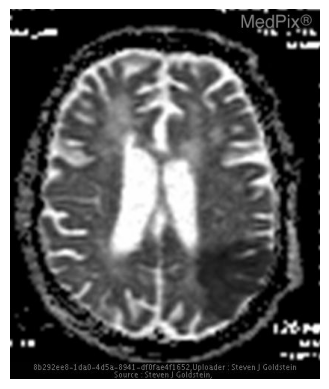

In [8]:
display_pil_image(vqa_rad['test'][100]['image'])

In [9]:
def clean_generation(response):
    """
    for some reason, the open-flamingo based model slightly changes the input prompt (e.g. prepends <unk>, an adds some spaces)
    """
    return response.replace('<unk> ', '').strip()

In [10]:
# Function to classify into open/close ended questions
def categorize_questions(dataset):
    close_ended_questions = []
    open_ended_questions = []

    for entry in dataset:
        if entry['answer'].lower() in ['yes', 'no']:
            close_ended_questions.append(entry)
        else:
            open_ended_questions.append(entry)

    return close_ended_questions, open_ended_questions

# Assuming vqa_rad is your dataset with 'train' and 'test' splits
train_close_ended, train_open_ended = categorize_questions(vqa_rad['train'])
test_close_ended, test_open_ended = categorize_questions(vqa_rad['test'])

# Displaying the number of each type
print(f"Training set: {len(train_close_ended)} close-ended, {len(train_open_ended)} open-ended")
print(f"Testing set: {len(test_close_ended)} close-ended, {len(test_open_ended)} open-ended")

Training set: 940 close-ended, 853 open-ended
Testing set: 251 close-ended, 200 open-ended


In [11]:
test_open_ended_answer = []
for i in test_open_ended:
    test_open_ended_answer.append(i['answer'])  
len(test_open_ended_answer)

200

In [12]:
test_close_ended_answer = []
for i in test_close_ended:
    test_close_ended_answer.append(i['answer'])
len(test_close_ended_answer)

251

In [13]:
train_close_ended_answer = []
for i in train_close_ended:
    train_close_ended_answer.append(i['answer'])
len(train_close_ended_answer)

940

In [41]:
test_answer = []
for i in vqa_rad['test']:
    test_answer.append(i['answer'])
len(test_answer)

451

# Med-Flamingo Model

In [14]:
from transformers import LlamaForCausalLM

old_forward = LlamaForCausalLM.forward

def forward(self, input_ids, attention_mask, **kwargs):
    """Condition the Flamingo layers on the media locations before forward()"""
    if not self.initialized_flamingo:
        raise ValueError(
            "Flamingo layers are not initialized. Please call `init_flamingo` first."
        )

    media_locations = input_ids == self.media_token_id

    # if there are media already cached and we're generating and there are no media tokens in the input,
    # we'll assume that ALL input tokens should attend to the last previous media that is cached.
    # this is especially important for HF generate() compatibility, since generate() calls forward()
    # repeatedly one token at a time (with no media tokens).
    # without this check, the model would not attend to any images when generating (after the first token)
    use_cached_media_locations = (
        self._use_cached_vision_x
        and self.is_conditioned()
        and not media_locations.any()
    )

    for layer in self._get_decoder_layers():
        if not use_cached_media_locations:
            layer.condition_media_locations(media_locations)
        layer.condition_use_cached_media(use_cached_media_locations)

    # package arguments for the other parent's forward. since we don't know the order of the arguments,
    # make them all kwargs
    kwargs["input_ids"] = input_ids
    kwargs["attention_mask"] = attention_mask
    return old_forward(self, **kwargs)  # Call the other parent's forward method

LlamaForCausalLM.forward = forward

In [15]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import open_clip

from open_flamingo.src.flamingo import Flamingo
from open_flamingo.src.flamingo_lm import FlamingoLMMixin
from open_flamingo.src.utils import extend_instance


def create_model_and_transforms(
    clip_vision_encoder_path: str,
    clip_vision_encoder_pretrained: str,
    lang_encoder_path: str,
    tokenizer_path: str,
    cross_attn_every_n_layers: int = 1,
    use_local_files: bool = False,
    decoder_layers_attr_name: str = None,
    freeze_lm_embeddings: bool = False,
    **flamingo_kwargs,
):
    """
    Initialize a Flamingo model from a pretrained vision encoder and language encoder.
    Appends special tokens to the tokenizer and freezes backbones.

    Args:
        clip_vision_encoder_path (str): path to pretrained clip model (e.g. "ViT-B-32")
        clip_vision_encoder_pretrained (str): name of pretraining dataset for clip model (e.g. "laion2b_s32b_b79k")
        lang_encoder_path (str): path to pretrained language encoder
        tokenizer_path (str): path to pretrained tokenizer
        cross_attn_every_n_layers (int, optional): determines how often to add a cross-attention layer. Defaults to 1.
        use_local_files (bool, optional): whether to use local files. Defaults to False.
        decoder_layers_attr_name (str, optional): name of the decoder layers attribute. Defaults to None.
    Returns:
        Flamingo: Flamingo model from pretrained vision and language encoders
        Image processor: Pipeline to preprocess input images
        Tokenizer: A tokenizer for the language model
    """
    vision_encoder, _, image_processor = open_clip.create_model_and_transforms(
        clip_vision_encoder_path, pretrained=clip_vision_encoder_pretrained
    )
    # set the vision encoder to output the visual features
    vision_encoder.visual.output_tokens = True

    text_tokenizer = AutoTokenizer.from_pretrained(
        tokenizer_path,
        local_files_only=use_local_files,
        trust_remote_code=True,
    )
    # add Flamingo special tokens to the tokenizer
    text_tokenizer.add_special_tokens(
        {"additional_special_tokens": ["<|endofchunk|>", "<image>"]}
    )
    if text_tokenizer.pad_token is None:
        # Issue: GPT models don't have a pad token, which we use to
        # modify labels for the loss.
        text_tokenizer.add_special_tokens({"pad_token": "<PAD>"})

    lang_encoder = AutoModelForCausalLM.from_pretrained(
        lang_encoder_path,
        local_files_only=use_local_files,
        trust_remote_code=True,
        load_in_4bit = True
    )

    # convert LM to FlamingoLM
    extend_instance(lang_encoder, FlamingoLMMixin)

    if decoder_layers_attr_name is None:
        decoder_layers_attr_name = _infer_decoder_layers_attr_name(lang_encoder)
    lang_encoder.set_decoder_layers_attr_name(decoder_layers_attr_name)
    lang_encoder.resize_token_embeddings(len(text_tokenizer))

    model = Flamingo(
        vision_encoder,
        lang_encoder,
        text_tokenizer.encode("<|endofchunk|>")[-1],
        text_tokenizer.encode("<image>")[-1],
        vis_dim=open_clip.get_model_config(clip_vision_encoder_path)["vision_cfg"][
            "width"
        ],
        cross_attn_every_n_layers=cross_attn_every_n_layers,
        **flamingo_kwargs,
    )

    # Freeze all parameters
    model.requires_grad_(False)
    assert sum(p.numel() for p in model.parameters() if p.requires_grad) == 0

    # Unfreeze perceiver, gated_cross_attn_layers, and LM input embeddings
    model.perceiver.requires_grad_(True)
    model.lang_encoder.gated_cross_attn_layers.requires_grad_(True)
    if not freeze_lm_embeddings:
        model.lang_encoder.get_input_embeddings().requires_grad_(True)
        # TODO: investigate also training the output embeddings when untied

    print(
        f"Flamingo model initialized with {sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable parameters"
    )

    return model, image_processor, text_tokenizer


def _infer_decoder_layers_attr_name(model):
    for k in __KNOWN_DECODER_LAYERS_ATTR_NAMES:
        if k.lower() in model.__class__.__name__.lower():
            return __KNOWN_DECODER_LAYERS_ATTR_NAMES[k]

    raise ValueError(
        f"We require the attribute name for the nn.ModuleList in the decoder storing the transformer block layers. Please supply this string manually."
    )


__KNOWN_DECODER_LAYERS_ATTR_NAMES = {
    "opt": "model.decoder.layers",
    "gptj": "transformer.h",
    "gpt-j": "transformer.h",
    "pythia": "gpt_neox.layers",
    "llama": "model.layers",
    "gptneoxforcausallm": "gpt_neox.layers",
    "mpt": "transformer.blocks",
    "mosaicgpt": "transformer.blocks",
}


In [16]:
from huggingface_hub import hf_hub_download
checkpoint_path = hf_hub_download("med-flamingo/med-flamingo", "model.pt")
print(f'Downloaded Med-Flamingo checkpoint to {checkpoint_path}')

import torch

a = torch.load(checkpoint_path, map_location="cuda")

Downloaded Med-Flamingo checkpoint to /home/sd4175/.cache/huggingface/hub/models--med-flamingo--med-flamingo/snapshots/7243cd83bd426ceade9c4de9844cc5e5f3ff75e0/model.pt


In [17]:
from huggingface_hub import hf_hub_download
import torch
import os
# from open_flamingo import create_model_and_transforms
from accelerate import Accelerator
from einops import repeat
from PIL import Image
import sys
sys.path.append('/content/med-flamingo/scripts')
sys.path.append('/content/med-flamingo')
from src.utils import FlamingoProcessor
from demo_utils import image_paths, clean_generation

accelerator = Accelerator() #when using cpu: cpu=True

device = accelerator.device
#add your local path to Llama-7B (v1) model here:
llama_path = "/vast/work/public/ml-datasets/llama-2/llama-2-7b"
if not os.path.exists(llama_path):
    raise ValueError('Llama model not yet set up, please check README for instructions!')
    
print('Loading model..')

model, image_processor, tokenizer = create_model_and_transforms(
    clip_vision_encoder_path="ViT-L-14",
    clip_vision_encoder_pretrained="openai",
    lang_encoder_path="huggyllama/llama-7b",
    tokenizer_path= "huggyllama/llama-7b",
    cross_attn_every_n_layers=4,
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Loading model..


Loading checkpoint shards: 100%|██████████| 2/2 [00:31<00:00, 15.66s/it]


Flamingo model initialized with 1309919248 trainable parameters


In [18]:
model.perceiver.cuda()
torch.cuda.empty_cache()
model.vision_encoder.cuda()
torch.cuda.empty_cache()
model.lang_encoder.gated_cross_attn_layers.to(torch.float16).cuda()
torch.cuda.empty_cache()

In [19]:
import gc  # Import the garbage collection module
# Collect and free up unused memory
gc.collect()

44

In [20]:
# load med-flamingo checkpoint:
model.load_state_dict(a, strict=False)
processor = FlamingoProcessor(tokenizer, image_processor)

# Output

In [21]:
def construct_single_prompt(dataset, index):
    data_point = dataset['test'][index]
    image = data_point['image']  # This is a PIL image
    question = data_point['question']
    answer = data_point['answer']

    # Construct the prompt
    prompt = (
        "You are a helpful medical assistant. You are being provided with images, "
        "a question about the image and an answer. Follow the examples and answer the last question.\n\n"
        "<image> Question: {} Answer: {}\n"  # Include more examples if needed
        "<image> Question: What is the most likely diagnosis?"
    ).format(question, answer)    
    return prompt, image

### Create Random Response Array

In [32]:
import random
from sentence_transformers import SentenceTransformer
train_set = vqa_rad['train']
test_set = vqa_rad['test']
# Number of examples you want to sample
num_examples = 5

# Generate random indices
train_indices = random.sample(range(len(train_set)), num_examples)

# Fetch examples using these indices
train_examples = [train_set[i] for i in train_indices]

# Randomly select an index for the test set
test_index = random.choice(range(len(test_set)))

# Fetch the test example using the index
test_example = test_set[test_index]

### Step 1: Load Images

In [33]:
# Extracting images from the training examples
demo_images = [ex['image'] for ex in train_examples]
# Adding the test image
test_image = test_example['image']
demo_images.append(test_image)


In [34]:
demo_images

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=444x454>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x1151>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=444x566>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=556x635>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x840>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x842>]

### Step 2: Create Prompt

In [35]:
# Constructing the prompt with examples and one test question
prompt = (
    "Imainge You are an expert in medical diagnosis. You are being provided with images, "
    "a question about the image and an answer. Follow the examples and answer the last question.\n\n" +
    "\n".join(f"<image> Question: {ex['question']} Answer: {ex['answer']}" for ex in train_examples) +
    f"\n<image> Question: {test_example['question']} Answer: "
)
prompt

'Imainge You are an expert in medical diagnosis. You are being provided with images, a question about the image and an answer. Follow the examples and answer the last question.\n\n<image> Question: is this an anoxic injury? Answer: yes\n<image> Question: what are the two hyperlucent inferior dots? Answer: nipple location\n<image> Question: is this a ct image? Answer: no\n<image> Question: what structures is identified in the middle of this image? Answer: pons\n<image> Question: is the et tube properly placed? Answer: yes\n<image> Question: is there cardiomegaly? Answer: '

### Step 3: Preprocess data

In [26]:
"""
Step 3: Preprocess data
"""
print('Preprocess data')

# Preprocess demo images using the FlamingoProcessor
pixels = processor.preprocess_images(demo_images)

pixels = repeat(pixels, 'N c h w -> b N T c h w', b=1, T=1)

# Encode the text prompt using the FlamingoProcessor
tokenized_data = processor.encode_text(prompt)


Preprocess data


### Step 4: Generate Response

In [27]:
print('Preprocess data')

# Convert image data to half precision
pixels_half = pixels.half().to(device)

# Keep text data in their original data type (usually Long)
input_ids = tokenized_data["input_ids"].to(device)  # No change to half
attention_mask = tokenized_data["attention_mask"].to(device)  # No change to half

print('Generate from multimodal few-shot prompt')

# Use mixed-precision training context for improved performance
with torch.autocast('cuda', torch.float16):

    # Generate text using the model
    generated_text = model.generate(
        vision_x=pixels.to(device),  # Convert images to the device
        lang_x=tokenized_data["input_ids"].to(device),  # Convert text input to the device
        attention_mask=tokenized_data["attention_mask"].to(device),  # Convert attention mask to the device
        max_new_tokens=10,  # Limit the maximum number of new tokens in the generated response
    )


response = processor.tokenizer.decode(generated_text[0])
response = clean_generation(response)

print(f'Response: {response}')


Preprocess data
Generate from multimodal few-shot prompt


/ext3/miniconda3/lib/python3.11/site-packages/bitsandbytes/nn/modules.py:226: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_type=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(f'Input type into Linear4bit is torch.float16, but bnb_4bit_compute_type=torch.float32 (default). This will lead to slow inference or training speed.')


Response: <s> Imainge You are an expert in medical diagnosis. You are being provided with images, a question about the image and an answer. Follow the examples and answer the last question.

<image>  Question: how many masses are there? Answer: one
<image>  Question: can you see kidneys in this image Answer: yes
<image>  Question: are the lesions in the cerebellum? Answer: yes
<image>  Question: what is the hypodensity on the posteriolateral edge of the left kidney? Answer: nephroblastomatosis
<image>  Question: is the heart border normal? Answer: no
<image>  Question: are liver findings normal? Answer: 2 liver nodules
 10


In [28]:
test_example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 'question': 'are liver findings normal?',
 'answer': 'yes'}

In [29]:
import re

# Regular expression to match the last occurrence of 'Answer: <answer>' and stop at newline
last_answer_match = re.search(r'Answer: ([^\n<]+)', response.split('<image>')[-1])

if last_answer_match:
    last_answer = last_answer_match.group(1).strip()
    print(f"Last Answer: {last_answer}")
else:
    print("No answer found.")

Last Answer: 2 liver nodules


## Responses for All test_dataset

In [30]:
all_responses_test = []
for test_entry in test_open_ended:
    # Construct the prompt for the current test entry
    prompt = (
        "Imagine You are an expert in medical diagnosis. You are being provided with images, "
        "a question about the image and an answer. Follow the examples and answer the last question.\n\n" +
        "\n".join(f"<image> Question: {ex['question']} Answer: {ex['answer']}" for ex in train_examples) +
        f"\n<image> Question: {test_entry['question']} Answer: "
    )

    # Preprocess the image from the test entry
    image_data = processor.preprocess_images([test_entry['image']])
    image_data = repeat(image_data, 'N c h w -> b N T c h w', b=1, T=1)

    # Encode the text prompt
    tokenized_data = processor.encode_text(prompt)

    # Convert image data to half precision and keep text data in their original data type
    pixels_half = image_data.half().to(device)

    # Generate the response using the model
    with torch.autocast('cuda', torch.float16):
        generated_text = model.generate(
            vision_x=pixels_half,
            lang_x=tokenized_data["input_ids"].to(device),
            attention_mask=tokenized_data["attention_mask"].to(device),
            max_new_tokens=10,
        )

    # Decode the generated text
    response = processor.tokenizer.decode(generated_text[0])
    response = clean_generation(response)

    # Extract the last answer and add to the array
    last_answer_match = re.search(r'Answer: ([^\n<]+)', response.split('<image>')[-1])
    if last_answer_match:
        last_answer = last_answer_match.group(1).strip()
    else:
        last_answer = "No answer found."
    print(last_answer)
    all_responses_test.append(last_answer)


right
2nd part of the left kidney
right
3rd part of the duodenum
↑↑↑↑↑↑↑↑↑↑
2 masses
pulmonary sequestration
3D reconstruction
pulmonary embolism
10 cm mass
2.5 cm
3D CT
100% of the time glioblast
hemosiderin deposits
supratentorial
10 mm of subcutaneous fat
10 cm mass
10 mm to the left of the sternum
10th thoracic vertebra
3D-T2-weighted
1. Aortic aneurysm
hypertrophic cardiomyopathy
pulmonary
2nd left lung zone


KeyboardInterrupt: 

In [ ]:
len(all_responses_test)

## Responses for All test_open_ended

In [ ]:
all_responses_toe = []
for test_entry in test_open_ended:
    # Construct the prompt for the current test entry
    prompt = (
        "Imagine You are an expert in medical diagnosis. You are being provided with images, "
        "a question about the image and an answer. Follow the examples and answer the last question.\n\n" +
        "\n".join(f"<image> Question: {ex['question']} Answer: {ex['answer']}" for ex in train_examples) +
        f"\n<image> Question: {test_entry['question']} Answer: "
    )

    # Preprocess the image from the test entry
    image_data = processor.preprocess_images([test_entry['image']])
    image_data = repeat(image_data, 'N c h w -> b N T c h w', b=1, T=1)

    # Encode the text prompt
    tokenized_data = processor.encode_text(prompt)

    # Convert image data to half precision and keep text data in their original data type
    pixels_half = image_data.half().to(device)

    # Generate the response using the model
    with torch.autocast('cuda', torch.float16):
        generated_text = model.generate(
            vision_x=pixels_half,
            lang_x=tokenized_data["input_ids"].to(device),
            attention_mask=tokenized_data["attention_mask"].to(device),
            max_new_tokens=10,
        )

    # Decode the generated text
    response = processor.tokenizer.decode(generated_text[0])
    response = clean_generation(response)

    # Extract the last answer and add to the array
    last_answer_match = re.search(r'Answer: ([^\n<]+)', response.split('<image>')[-1])
    if last_answer_match:
        last_answer = last_answer_match.group(1).strip()
    else:
        last_answer = "No answer found."
    print(last_answer)
    all_responses_toe.append(last_answer)


In [ ]:
len(all_responses_toe)

## Responses for All test_close_ended

In [ ]:
all_responses_tcs = []
for test_entry in test_close_ended:
    # Construct the prompt for the current test entry
    prompt = (
    "Imainge You are an expert in medical diagnosis. You are being provided with images, "
    "a question about the image and an answer with yes or no. Follow the examples and answer the last question with purely yes or no.\n\n" +
    "\n".join(f"<image> Question: {ex['question']} Answer: {ex['answer']}" for ex in train_examples) +
    f"\n<image> Question: {test_entry['question']} Answer: "
    )

    # Preprocess the image from the test entry
    image_data = processor.preprocess_images([test_entry['image']])
    image_data = repeat(image_data, 'N c h w -> b N T c h w', b=1, T=1)

    # Encode the text prompt
    tokenized_data = processor.encode_text(prompt)

    # Convert image data to half precision and keep text data in their original data type
    pixels_half = image_data.half().to(device)

    # Generate the response using the model
    with torch.autocast('cuda', torch.float16):
        generated_text = model.generate(
            vision_x=pixels_half,
            lang_x=tokenized_data["input_ids"].to(device),
            attention_mask=tokenized_data["attention_mask"].to(device),
            max_new_tokens=10,
        )

    # Decode the generated text
    response = processor.tokenizer.decode(generated_text[0])
    response = clean_generation(response)

    # Extract the last answer and add to the array
    last_answer_match = re.search(r'Answer: ([^\n<]+)', response.split('<image>')[-1])
    if last_answer_match:
        last_answer = last_answer_match.group(1).strip()
    else:
        last_answer = "No answer found."
    print(last_answer)
    all_responses_tcs.append(last_answer)


In [ ]:
len(all_responses_tcs)

In [ ]:
len(test_close_ended_answer )

## Responses for All test_dataset

In [37]:
all_responses_test = []
for test_entry in vqa_rad['test']:
    # Construct the prompt for the current test entry
    prompt = (
        "Imagine You are an expert in medical diagnosis. You are being provided with images, "
        "a question about the image and an answer. Follow the examples and answer the last question.\n\n" +
        "\n".join(f"<image> Question: {ex['question']} Answer: {ex['answer']}" for ex in train_examples) +
        f"\n<image> Question: {test_entry['question']} Answer: "
    )

    # Preprocess the image from the test entry
    image_data = processor.preprocess_images([test_entry['image']])
    image_data = repeat(image_data, 'N c h w -> b N T c h w', b=1, T=1)

    # Encode the text prompt
    tokenized_data = processor.encode_text(prompt)

    # Convert image data to half precision and keep text data in their original data type
    pixels_half = image_data.half().to(device)

    # Generate the response using the model
    with torch.autocast('cuda', torch.float16):
        generated_text = model.generate(
            vision_x=pixels_half,
            lang_x=tokenized_data["input_ids"].to(device),
            attention_mask=tokenized_data["attention_mask"].to(device),
            max_new_tokens=10,
        )

    # Decode the generated text
    response = processor.tokenizer.decode(generated_text[0])
    response = clean_generation(response)

    # Extract the last answer and add to the array
    last_answer_match = re.search(r'Answer: ([^\n<]+)', response.split('<image>')[-1])
    if last_answer_match:
        last_answer = last_answer_match.group(1).strip()
    else:
        last_answer = "No answer found."
    print(last_answer)
    all_responses_test.append(last_answer)


2 aneurysms
2+
2
left
2nd level of the right renal artery
2 kidneys
left
10th
↑
no
no
1. et tube, 2. p
100% oxygen saturation
100%
no
100%
3D
2 kidneys
yes
no
10 cm mass
no
3D
no
2nd part of duodenum
3d
no
3rd ventricle
1. Cerebral hemorrhage
1- blood products, 2- edema
no
no
supratentorial
no
no
20%
2nd image shows normal kidneys
2nd image shows normal kidneys
2 of 3 are visible
2 of 3 are seen
subcutaneous fat
subcutaneous fat
no
no
2nd lumbar vertebrae
2nd lumbar fracture
no
100% yes
no
10th rib
10th rib
2+
2+
10 cm
10 cm
100%
100% yes
no
100%
100% yes
no
no
3D
2 o’clock
2nd and 3rd
100% pneumonia
pneumothorax
pulmonary
2 loops of bowel are identified
2 days after the injury
no
2nd left
2nd left
2+
yes
1st
10th rib
10th rib
body
100% yes
3d
100% liver
4th
no
2nd rib fracture
3D
MRI
no
2
1st lumbar vertebra
100% yes
100% yes
1.5 cm left frontal lesion
no
100% yes
right
right
1st part of the renal vein
1st part of the inferior vena cava
no
no
100%
left
right
3rd ventricle
1st rib
4th


In [40]:
len(all_responses_test)

451

## Responses for All test_open_ended# Evaluation

## Evaluation I

In [45]:
from torch.nn.functional import cosine_similarity

### Evaluation for All test_open_ended

In [ ]:
model = SentenceTransformer('bert-base-nli-mean-tokens')
# Compute embeddings for generated responses and actual answers
response_embeddings = model.encode( all_responses_toe, convert_to_tensor=True)
actual_answer_embeddings = model.encode(test_open_ended_answer, convert_to_tensor=True)
# Calculate similarities and store them
similarities = [cosine_similarity(response_embeddings[i].unsqueeze(0), actual_answer_embeddings[i].unsqueeze(0)).item() for i in range(len( all_responses_toe))]


In [ ]:
# Calculate the average similarity score
average_similarity = sum(similarities) / len(similarities)
print(f"Average Similarity Score: {average_similarity}")

### Evaluation for All test_close_ended

In [38]:
model = SentenceTransformer('bert-base-nli-mean-tokens')
# Compute embeddings for generated responses and actual answers
response_embeddings = model.encode(all_responses_tcs, convert_to_tensor=True)
actual_answer_embeddings = model.encode(test_close_ended_answer , convert_to_tensor=True)
# Calculate similarities and store them
similarities = [cosine_similarity(response_embeddings[i].unsqueeze(0), actual_answer_embeddings[i].unsqueeze(0)).item() for i in range(len(all_responses_tcs))]


NameError: name 'all_responses_tcs' is not defined

In [ ]:
# Calculate the average similarity score
average_similarity = sum(similarities) / len(similarities)
print(f"Average Similarity Score: {average_similarity}")

In [ ]:
similarities

### Evaluation for All test_dataset

In [46]:
model = SentenceTransformer('bert-base-nli-mean-tokens')
# Compute embeddings for generated responses and actual answers
response_embeddings = model.encode(all_responses_test, convert_to_tensor=True)
actual_answer_embeddings = model.encode(test_answer , convert_to_tensor=True)
# Calculate similarities and store them
similarities = [cosine_similarity(response_embeddings[i].unsqueeze(0), actual_answer_embeddings[i].unsqueeze(0)).item() for i in range(len(all_responses_test))]


In [47]:
similarities

[0.3709644675254822,
 0.6998100280761719,
 0.6509072780609131,
 0.6557656526565552,
 0.12389564514160156,
 0.35007786750793457,
 0.9999999403953552,
 0.5537238121032715,
 0.5003594160079956,
 0.9999999403953552,
 0.5917752981185913,
 0.40330642461776733,
 0.5120455026626587,
 0.42404353618621826,
 0.9999999403953552,
 0.42404353618621826,
 0.5098439455032349,
 0.4953263998031616,
 0.5917751789093018,
 0.9999999403953552,
 0.34235844016075134,
 0.9999999403953552,
 0.701866626739502,
 0.9999999403953552,
 0.4727887809276581,
 0.612319827079773,
 0.9999999403953552,
 0.4104499816894531,
 0.5977427959442139,
 0.4789176881313324,
 0.9999999403953552,
 0.9999999403953552,
 0.9999999403953552,
 0.9999999403953552,
 0.5917751789093018,
 0.43575286865234375,
 0.3373001515865326,
 0.3373001515865326,
 0.5928628444671631,
 0.5089258551597595,
 0.6947284936904907,
 0.6947284936904907,
 1.0000001192092896,
 1.0000001192092896,
 0.25426924228668213,
 0.3618372678756714,
 0.5917751789093018,
 0.4229

In [48]:
# Calculate the average similarity score
average_similarity = sum(similarities) / len(similarities)
print(f"Average Similarity Score: {average_similarity}")

Average Similarity Score: 0.6135844466361132
